# Исследование влияния архитектурных изменений сверточной нейронной сети на качество распознавания на примере набора MNIST

Проведите серию экспериментов по подбору гиперпараметров нейронной сети, созданной на занятии.

1. Поменяйте количество нейронов в сверточных слоях, использовав следующие значения:

    - один слой 2 нейрона
    - один слой 4 нейрона
    - один слой 16 нейронов

2. Поменяйте активационную функцию в скрытых слоях с `relu` на `linear`
3. Поменяйте размеры `batch_size`:

    - 10
    - 100
    - Вся база (50000)

4. Запишите в таблицу получившиеся точности.
5. Напишите выводы по результатам проведенных тестов.

In [1]:
import logging
import os
from pathlib import Path
import sys
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Задать количество эпох для обучения.

In [4]:
EPOCHS = 15

Создать датафрейм для хранения результатов тестирования.

In [5]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['train', 'validation', 'test']
)

Определить вспомогательную функцию для визуализации процесса обучения.

In [6]:
def plot_history(
    history: History, 
    subtitle: str, 
    axes: Optional[np.ndarray] = None
) -> None:
    if axes is None or not axes.all():
        _, axes = plt.subplots(1, 2, figsize=(12, 4))
        show_plot = True
    else:
        show_plot = False

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='train set'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='validation set'
    )
    axes[0].set_title(f"Изменение loss: {subtitle}")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='train set'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='validation set'
    )
    axes[1].set_title(f"Изменение accuracy: {subtitle}")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    if show_plot:
        plt.show()

## Подготовка данных

Загрузка данных MNIST:

In [7]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [8]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора

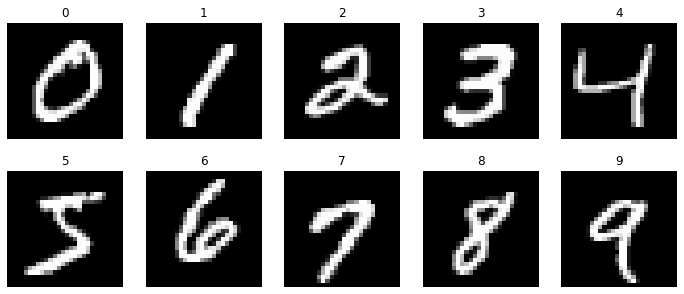

In [9]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [10]:
x = x_org[:, :, :, np.newaxis] / 255
x_test = x_test_org[:, :, :, np.newaxis] / 255

In [11]:
print(f"{x.shape}, {x_test.shape}")

(60000, 28, 28, 1), (10000, 28, 28, 1)


Преобразовать ответы в унитарный код (one-hot)

In [12]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [13]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


Выделить обучающую и валидационную выборки.

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [15]:
print(f"{x_train.shape}, {x_val.shape}")

(48000, 28, 28, 1), (12000, 28, 28, 1)


## Создание и обучение эталонной модели сверточной нейронной сети

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [16]:
class ConvNet:

    @staticmethod
    def build(conv_layers: Tuple[int,...], activation='relu') -> Sequential:
        model = Sequential()

        model.add(BatchNormalization(input_shape=(28, 28, 1)))
        for channels in conv_layers:
            model.add(
                Conv2D(
                    channels,
                    (3, 3),
                    padding='same',
                    activation=activation
                )
            )
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(256, activation=activation))
        model.add(Dropout(0.25))
        model.add(Dense(10, activation='softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy']
        )

        return model

Создать эталонную модель сверточной нейронной сети:

In [17]:
net = ConvNet.build(conv_layers=(32, 32))

print(net.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1605888   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

Обучить нейронную сеть.

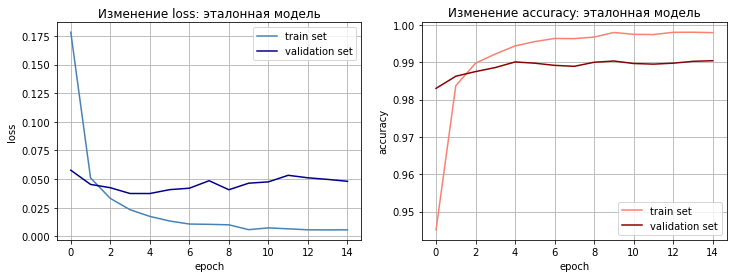

In [18]:
history = net.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=0
)

plot_history(history, subtitle="эталонная модель");

Сохранить веса нейронной сети.

In [19]:
path = Path.home() / 'aiu-03-mnist-light-model-32+32'

net.save(path)

Получить значения loss и accuracy для тестовой выборки.

In [20]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.04158
Test accuracy: 0.99090


Записать результаты в отчет.

In [21]:
def update_report(
    report: pd.DataFrame,
    category: str,
    value: str,
    history: History,
    score: List[int]
) -> None:
    report.loc[(category, value), :] = [
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1]
    ]

In [22]:
update_report(report, "Эталонная модель", "(32, 32)", history, score)

## Исследование влияния количества нейронов в сверточных слоях

Создать список, в котором заданы количество нейронов в сверточных слоях.

In [23]:
conv_layers_lst = [(j, 32) if i == 0 else (32, j) for i in range(2)
                                                  for j in (2, 4, 16)]

Обучить нейронные сети заданной архитектуры.

Done: 100%|██████████| 6/6 [01:53<00:00, 18.96s/it]


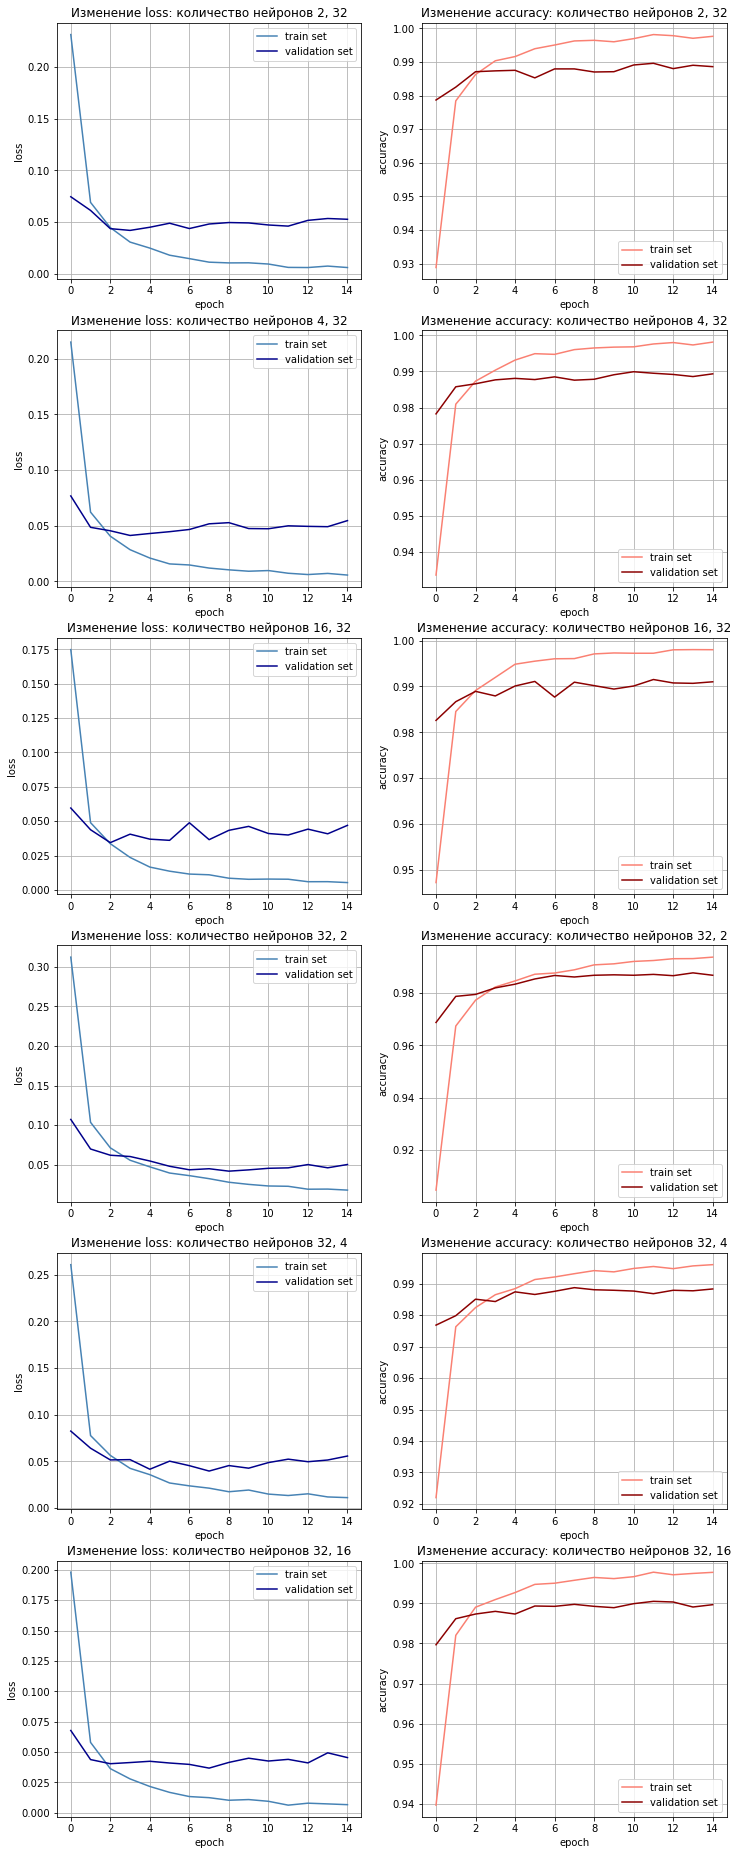

In [24]:
_, axes = plt.subplots(
    len(conv_layers_lst), 
    2,
    figsize=(12, 5.5 * len(conv_layers_lst))
)
axes = axes.flatten()

with tqdm(total=len(conv_layers_lst), desc="Fitting", file=sys.stdout) as pbar:
    for i, conv_layers in enumerate(conv_layers_lst):
        net = ConvNet.build(conv_layers=conv_layers)

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle="количество нейронов {}, {}".format(*conv_layers),
            axes=axes[2*i:2*i+2]
        )

        net.save(Path.home() / 'aiu-03-mnist-light-model-{}+{}'.format(*conv_layers))

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Количество нейронов",
            str(conv_layers),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

In [25]:
report

train validation    test
Категория           Значение                             
Эталонная модель    (32, 32)  0.997938   0.990417  0.9909
Количество нейронов (2, 32)   0.997604   0.988583  0.9889
                    (4, 32)   0.998125   0.989333  0.9888
                    (16, 32)     0.998      0.991  0.9903
                    (32, 2)   0.993771   0.986833  0.9861
                    (32, 4)   0.996063   0.988333  0.9883
                    (32, 16)  0.997729   0.989667  0.9894